Reference Paper: "Estimating the Basin of Attraction for the Power Flow Equations in Power Distribution Networks"
DOI: 10.1109/TPWRS.2024.3437649

---
---

The goal is to estimate both the inner and outer boundaries of the basin of attraction in power distribution networks. The proposed approach helps define the convergence region of the power flow algorithm and estimates the grid’s minimum and maximum voltage levels without directly solving the power flow equations.

Parameters definitions:

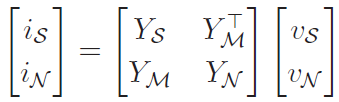



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import pandapower as pp

In [2]:
# Create a simple power network using pandapower including seven buses
net = pp.networks.example_simple()

# Function to perform power flow calculation using Newton-Raphson method
def power_flow_calculation(net):
    pp.runpp(net, calculate_voltage_angles=True)
    return np.concatenate((net.res_bus.vm_pu.values, net.res_bus.va_degree.values))

# Run power flow
power_flow_calculation(net)

# Access internal states
internal = net._ppc["internal"]

# Access P value
pn = internal["Pbusinj"]
pn = pn[0:pn.size]

# Define Voltage of slack bus
vs = 1.0

# Access Y-bus matrix
Y_0 = internal["Ybus"]  
Y = Y_0.toarray()

# Creat the admittance matrix
Zn = np.linalg.inv(Y[0:Y.size, 0:Y.size])

# slicing the array Y
Ym = Y[0:Y.size, 0]

# T: B → X be a contraction which moves the center of B a distance at most (1 − γ)r
def T(v):
    return Zn @ (pn / v - Ym * vs)

# Receive voltage values
real_values = power_flow_calculation(net)
vn = real_values[1:7]

# Define alpha parameter 
α1 = np.linalg.norm(Zn @ pn, np.inf) * 0.1
α2 = np.linalg.norm(vn - Zn @ (pn / vn - Ym * vs), np.inf) * 0.1


print(f"alpha_1 is {"{:e}".format(α1)}")
print(f"alpha_2 is {"{:e}".format(α2)}")

# Define polynomial function
pol = Polynomial([-α2, 1 + 2 * α2 - α1, -2 - α2, 1])

# Calculate theradius of our solution domain (closed ball)
r = np.sort(pol.roots().real)
rmin = r[1] * 0.1
rmax = r[2] * 0.1

# Print the calculated parameters
print(f"vmin(est): {vn - rmin}")
print(f"vmax(est): {vn + rmax}")
print(f"rmin: {rmin}")
print(f"rmax: {rmax}")

alpha_1 is 1.598397e+01
alpha_2 is 1.559834e+01
vmin(est): [0.97504004 0.97504004 0.97877295 0.97877295 0.98421054 0.97741587]
vmax(est): [2.68908459 2.68908459 2.6928175  2.6928175  2.69825508 2.69146042]
rmin: 0.045789464242144834
rmax: 1.6682550829011633


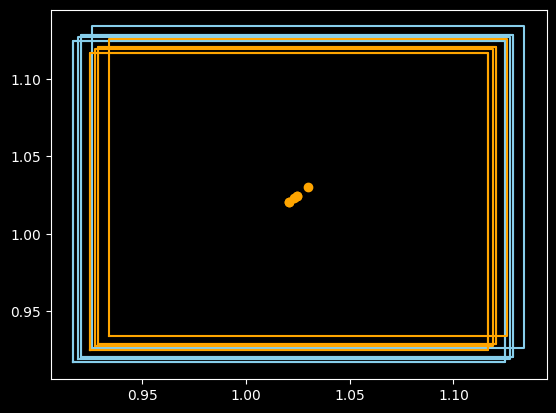

In [3]:
# Plot the center (orange dots) of voltage magnitudes domain and max (blue squares) and min (orange squares) domain for contraction purpose

vf = np.zeros((2, 10))
vf[:, 0] = np.array([0.4, 0.4])

plt.style.use('dark_background')
plt.plot([vn - rmax, vn - rmax, vn + rmax, vn + rmax, vn - rmax],
         [vn - rmax, vn + rmax, vn + rmax, vn - rmax, vn - rmax],
         color='skyblue')
plt.plot([vn - rmin, vn - rmin, vn + rmin, vn + rmin, vn - rmin],
         [vn - rmin, vn + rmin, vn + rmin, vn - rmin, vn - rmin],
         color='orange')
plt.plot([vn], [vn], marker='o', color='orange')

plt.show()